In [92]:
from matplotlib import pyplot as plt 
import numpy as np 
import pickle as pkl
import os
from scipy.stats import spearmanr
import pandas as pd
from sklearn.metrics import roc_auc_score

import sys 
sys.path.append('../src/')
from utils import load_config, get_corruption_scores

# Load results

In [136]:
out_dir = '../results/exp3'

res = pd.read_csv(f'{out_dir}/results.csv', sep='\t')
res.tail()

,uid,config,config-checksum,method,perf_filter_low,perf_filter_high,runtime_s
0,e6bd0c83-da08-45bd-b8f9-1cd443baf6f7,../configs/exp3.py,99e77144021de88483cc9443d7997e3c,dvgs,"[0.7775000000000001, 0.799, 0.8089999999999999...","[0.7815000000000001, 0.7875000000000001, 0.758...",98.187989
1,e195247e-f26e-48ee-9093-96aacee5ffe8,../configs/exp3.py,e53bc460eaf2dff8a8c24c0150bcfcb7,dvgs,"[0.7765, 0.7945, 0.8165, 0.8095, 0.824, 0.8140...","[0.7945, 0.7885, 0.7575000000000001, 0.6815, 0...",185.549272
2,a30ffede-4546-4ff2-8204-68bb4e5c33d4,../configs/exp3.py,b41b2d249bd7ada85234923ea4cf1beb,dvrl,"[0.773, 0.791, 0.7925, 0.742, 0.722, 0.673, 0....","[0.79, 0.7735000000000001, 0.787, 0.6895, 0.69...",1548.358409
3,249531f6-ff41-4dc9-8154-f05615073f66,../configs/exp3.py,54b23a3318bffc3602e9c87013cd36a2,dvrl,"[0.782, 0.7865, 0.794, 0.777, 0.7885, 0.8, 0.8...","[0.769, 0.734, 0.6995, 0.559, 0.61949999999999...",1581.524902
4,c50e39c4-5dc3-4d9e-9a29-5c88bbd18b21,../configs/exp3.py,f52dcdfe07eacee87fb9b19571bc429d,dvrl,"[0.7895000000000001, 0.802, 0.8, 0.72, 0.8105,...","[0.7805, 0.7495, 0.7135, 0.6545000000000001, 0...",670.568491


In [137]:
res = res.iloc[[0,1,3,4]]

In [138]:
vals_dict = {uid:
                {
                 'vals':np.load(f'{out_dir}/data_values/{uid}/data_values.npy'), 
                 'exog':np.load(f'{out_dir}/data_values/{uid}/exog_noise.npy'),
                 'endog':np.load(f'{out_dir}/data_values/{uid}/endog_noise.npy')
                } 
            for uid in res.uid.values}

In [139]:
# check that all config-checksums are identical; if not, it may have changed between runs 
if res['config-checksum'].unique().shape[0] > 1: 
    print('WARNING! config checksums are not identical, config file may have changed between runs.')

# check that the same config file was used 
if res['config'].unique().shape[0] > 1: 
    print('WARNING! Different config. files were used between runs.')

WARNING! config checksums are not identical, config file may have changed between runs.


In [140]:
config = load_config(res.config.values[0])

Using cache found in /home/teddy/.cache/torch/hub/pytorch_vision_v0.10.0
/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# corrupted label identification 

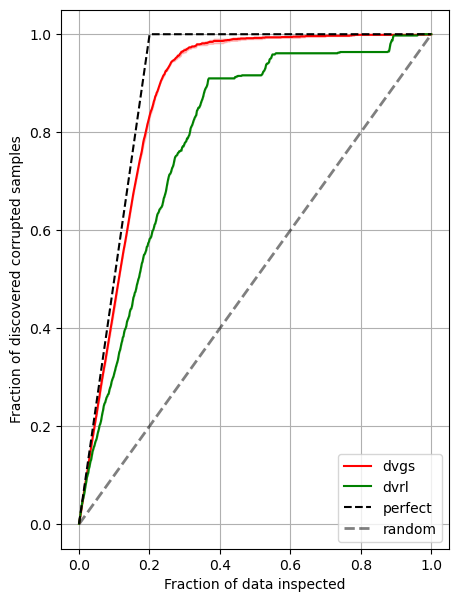

In [141]:
auroc = {m:[] for m in res.method.unique()}

plt.figure(figsize=(5, 7))

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    pp_corr = []
    for i,row in _temp.iterrows(): 

        noise_labels = vals_dict[row.uid]['endog']
        noise_idx = noise_labels.nonzero()[0]
        vals = vals_dict[row.uid]['vals']

        auroc[method].append(roc_auc_score(noise_labels, -vals))

        pk, p_corr, p_perfect, p_random = get_corruption_scores(vals, noise_idx, config.train_num, config.endog_noise)
        pp_corr.append(p_corr)

    pp_corr = np.stack(pp_corr, axis=0)

    plt.plot(pk, np.quantile(a=pp_corr, q=0.5, axis=0), color=c, label=method)
    plt.fill_between(pk, np.quantile(a=pp_corr, q=0.05, axis=0), np.quantile(a=pp_corr, q=0.95, axis=0), color=c, alpha=0.2)

plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'k--', label='random', linewidth=2, alpha=0.5)

plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(visible=None)
plt.show()

        


In [132]:
noise_labels[vals <= np.quantile(vals, 0.2)].sum()

482.0

In [133]:
table_latex = [[config.dataset]]
for method in ['dvgs', 'dshap', 'dvrl', 'loo', 'random']: 
    if method in auroc: 
        table_latex.append( [f'{np.mean(auroc[method]):.3f} $\pm$ {2*np.std(auroc[method]):.3f}'] )
    else: 
        table_latex.append(['NA'])

table_latex = pd.DataFrame(table_latex).T 
table_latex.columns= ['Dataset', 'dvgs', 'dshap', 'dvrl', 'loo', 'random']

print()
#table_latex.style.to_latex()

In [134]:
table_latex

,Dataset,dvgs,dshap,dvrl,loo,random
0,cifar10,0.968 $\pm$ 0.005,NA,0.870 $\pm$ 0.000,NA,NA


# Filtered Data Performance

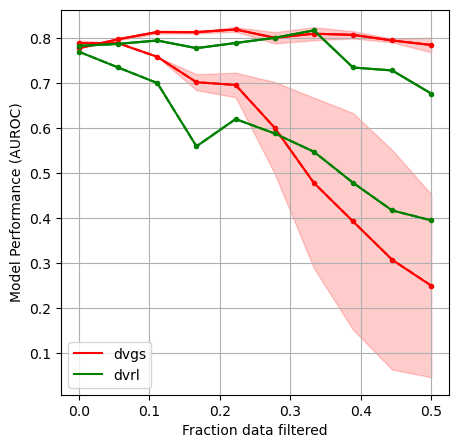

In [135]:
plt.figure(figsize=(5, 5))

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    _low = [] 
    _high = [] 
    for i,row in _temp.iterrows(): 
        _low.append(row.perf_filter_low.strip('[]').split(','))
        _high.append(row.perf_filter_high.strip('[]').split(','))

    _low = np.stack(_low, axis=0).astype(float)
    _high = np.stack(_high, axis=0).astype(float)

    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, label=method, linestyle='-')
    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, marker='.')
    plt.fill_between(config.filter_kwargs['qs'], np.quantile(a=_low, q=0.05, axis=0), np.quantile(a=_low, q=0.95, axis=0), color=c, alpha=.2)

    plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, linestyle='--')
    plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, marker='.', linestyle=None)
    plt.fill_between(config.filter_kwargs['qs'], np.quantile(a=_high, q=0.05, axis=0), np.quantile(a=_high, q=0.95, axis=0), color=c, alpha=.2)

plt.legend()
plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance (AUROC)')
plt.grid(visible=None)
plt.show()